## Importing Libraries

In [8]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from PIL import Image
import io
import seaborn as sns
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

## Data Loading

In [9]:
img_dim = 256
num_classes = 5

class NPYDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images_path, masks_path, batch_size=32, dim=(256, 256), n_channels=3, n_classes=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.image_ids = [os.path.splitext(file)[0] for file in os.listdir(images_path)]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_ids_temp = [self.image_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_ids_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_ids_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes))

        # Generate data
        for i, ID in enumerate(image_ids_temp):
            # Store sample
            image_path = os.path.join(self.images_path, ID + '.jpg')
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.dim)
            image = image / 255.0  # Normalize to [0, 1]
            X[i,] = image

            # Store class
            mask_path = os.path.join(self.masks_path, ID + '.npy')
            mask = np.load(mask_path)
            y[i,] = mask

        return X, y


# Set up the paths for the training and validation images and masks
train_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/train' # Replace with your path to training images
train_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/train' # Replace with your path to training masks

val_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/valid' # Replace with your path to validation images
val_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/valid' # Replace with your path to validation masks

test_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/test' # Replace with your path to training images
test_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/test'
# Create the data generators
train_generator = NPYDataGenerator(train_images_path, train_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=True)
val_generator = NPYDataGenerator(val_images_path, val_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=False)
test_generator = NPYDataGenerator(test_images_path, test_masks_path, batch_size=32, dim=(img_dim, img_dim), n_channels=3, n_classes=num_classes, shuffle=False)

## One hot Encoding of the Images

In [ ]:
def one_hot_encode(mask_directory,output_directory):
    os.makedirs(output_directory, exist_ok=True)
    unique_colors = [[  0,   0,   0], # black
        [  0, 128, 128],
        [ 38,  75, 110],
        [235, 206, 135],
        [255, 255, 255]] 

    def one_hot_encode_mask(mask, unique_colors):
        one_hot_mask = np.zeros((*mask.shape[:2], len(unique_colors)), dtype=np.uint8)
        for idx, color in enumerate(unique_colors):
            class_mask = np.all(mask == color, axis=-1)
            one_hot_mask[..., idx] = class_mask.astype(np.uint8)  
        return one_hot_mask

    # Iterate through mask images in the directory
    for filename in os.listdir(mask_directory):
        if filename.endswith('.png'):  # Assuming mask images are in PNG format
            # Load the mask image
            mask_image_path = os.path.join(mask_directory, filename)
            mask_image = cv2.imread(mask_image_path, cv2.IMREAD_UNCHANGED)
            mask_image = np.transpose(mask_image, (1, 0, 2))
            filtered_unique_colors = unique_colors[:]
            one_hot_encoded_mask = one_hot_encode_mask(mask_image, filtered_unique_colors)   
            output_filename = os.path.join(output_directory, filename.replace('.png', '.npy'))
            np.save(output_filename, one_hot_encoded_mask)

## Visulizing The Data

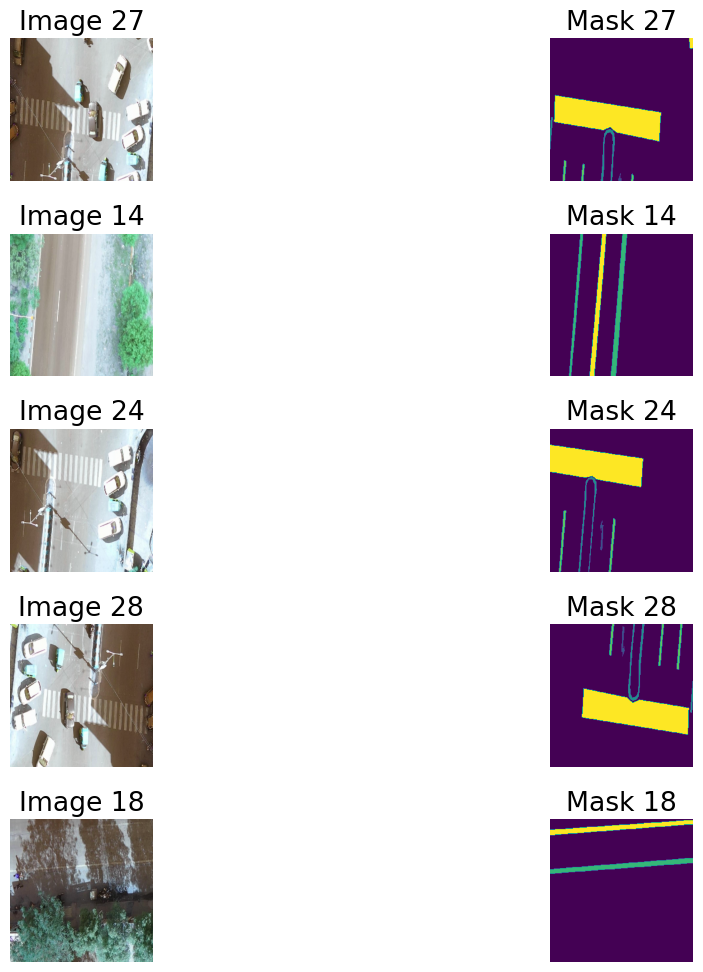

In [10]:
import matplotlib.pyplot as plt

def visualize_batch(generator, num_images=5):
    # Generate a batch of data
    X, y = generator[0]  # Get the first batch from the generator
    
    # Select num_images random indices from the batch
    indices = np.random.choice(range(X.shape[0]), size=num_images, replace=False)
    
    # Plot the images and masks
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        # Plot original image
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(X[idx])
        plt.title(f'Image {idx}')
        plt.axis('off')

        # Plot mask (assuming mask is a one-hot encoded array)
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(np.argmax(y[idx], axis=-1), cmap='viridis')  # Displaying mask as an image
        plt.title(f'Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training images and masks
visualize_batch(train_generator, num_images=5)


## Defining Model Architecture

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape,num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss='categorical_crossentropy', # Use 'categorical_crossentropy' for multi-class
metrics=['accuracy']) # It's better to start with 'accuracy'
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_23[0][0] 

 Total params: 7,772,005 (29.65 MB)

 Trainable params: 7,766,117 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Creating function for Early Stopping

In [99]:
import tensorflow as tf

def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou


# Use IoU in your model's metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[iou_coef, 'accuracy'])

checkpoint = ModelCheckpoint(
    'unet_multiclass_iou.keras', 
    monitor='val_iou_coef',
    verbose=1, 
    save_best_only=True, 
    mode='max'
)
# Early stopping based on IoU
earlystop = EarlyStopping(monitor='val_iou_coef', 
                          patience=10, 
                          verbose=1, 
                          mode='max',
                          restore_best_weights=True)



## Loading Training and Validation data for Model Training

In [18]:
# Next, create instances of the NPYDataGenerator for training and validation data
train_data_generator = NPYDataGenerator(
    images_path='/kaggle/input/cv-road-marking/augmented_dataset/images/train',  # Replace with your train images .npy path
    masks_path='/kaggle/input/cv-road-marking/augmented_dataset/masks/train',    # Replace with your train masks .npy path
    batch_size=32,
    dim=(img_dim, img_dim),
    n_channels=3,
    n_classes=num_classes,  # Replace with your actual number of classes
    shuffle=True
)

val_data_generator = NPYDataGenerator(
    images_path='/kaggle/input/cv-road-marking/augmented_dataset/images/valid',  # Replace with your validation images .npy path
    masks_path='/kaggle/input/cv-road-marking/augmented_dataset/masks/valid',    # Replace with your validation masks .npy path
    batch_size=32,
    dim=(img_dim, img_dim),
    n_channels=3,
    n_classes=num_classes,  # Replace with your actual number of classes
    shuffle=True
)

## Training the model

In [19]:
history = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.7315 - iou_coef: 0.3042 - loss: 0.9524
Epoch 1: iou_coef improved from -inf to 0.43229, saving model to unet_multiclass_iou.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 739ms/step - accuracy: 0.7341 - iou_coef: 0.3069 - loss: 0.9462 - val_accuracy: 0.8365 - val_iou_coef: 0.2644 - val_loss: 0.9388
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9247 - iou_coef: 0.6386 - loss: 0.3473
Epoch 2: iou_coef improved from 0.43229 to 0.66154, saving model to unet_multiclass_iou.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 35s 678ms/step - accuracy: 0.9248 - iou_coef: 0.6390 - loss: 0.3468 - val_accuracy: 0.7754 - val_iou_coef: 0.4026 - val_loss: 1.3337
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9361 - iou_coef: 0.7305 - loss: 0.2588
Epoch 3: iou_coef improved from 0.66154 to 0.74024, saving model to unet_multiclass_iou.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 674ms/step - accuracy: 0.9361 - iou_coef: 0.7307 - loss

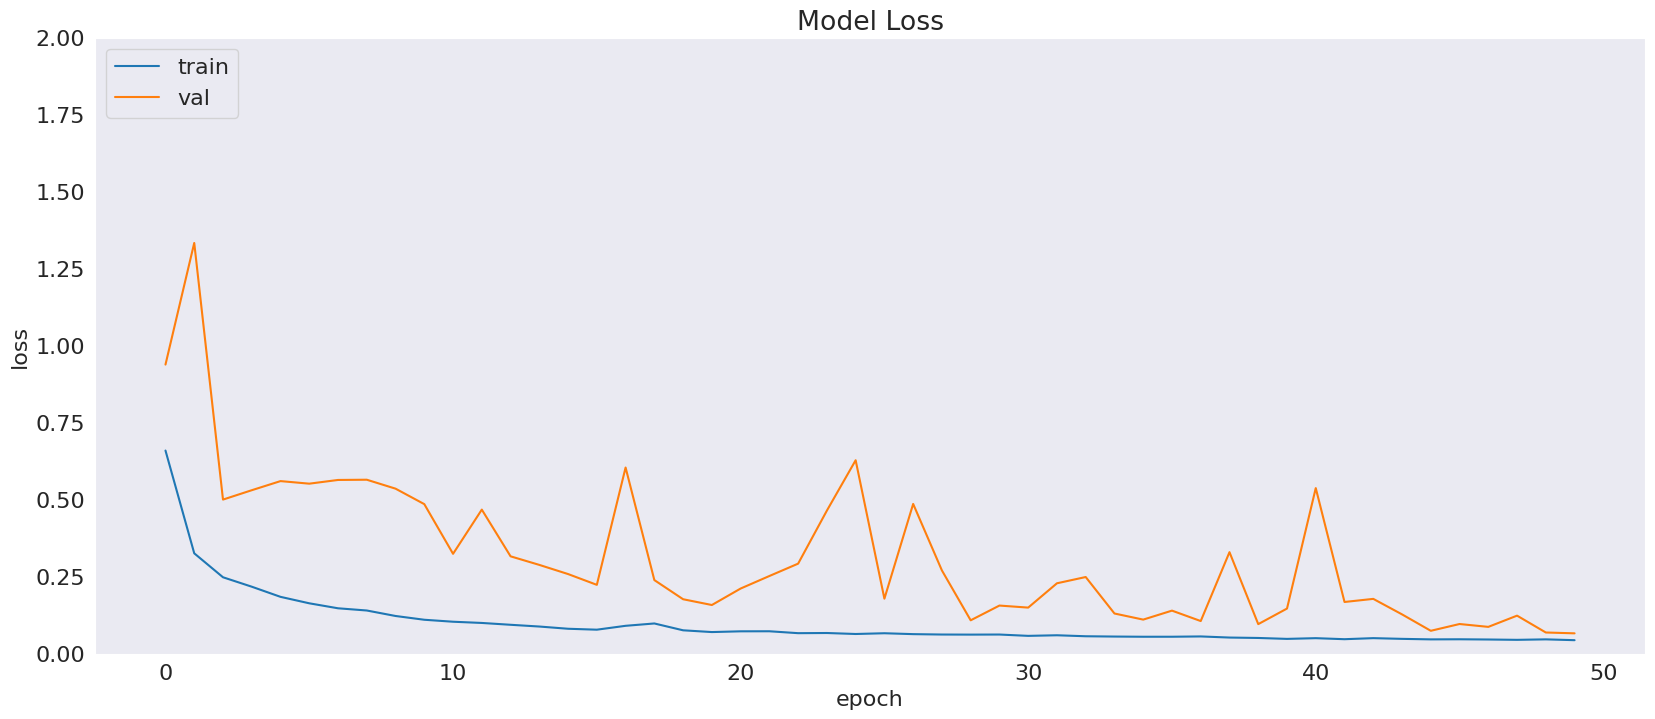

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


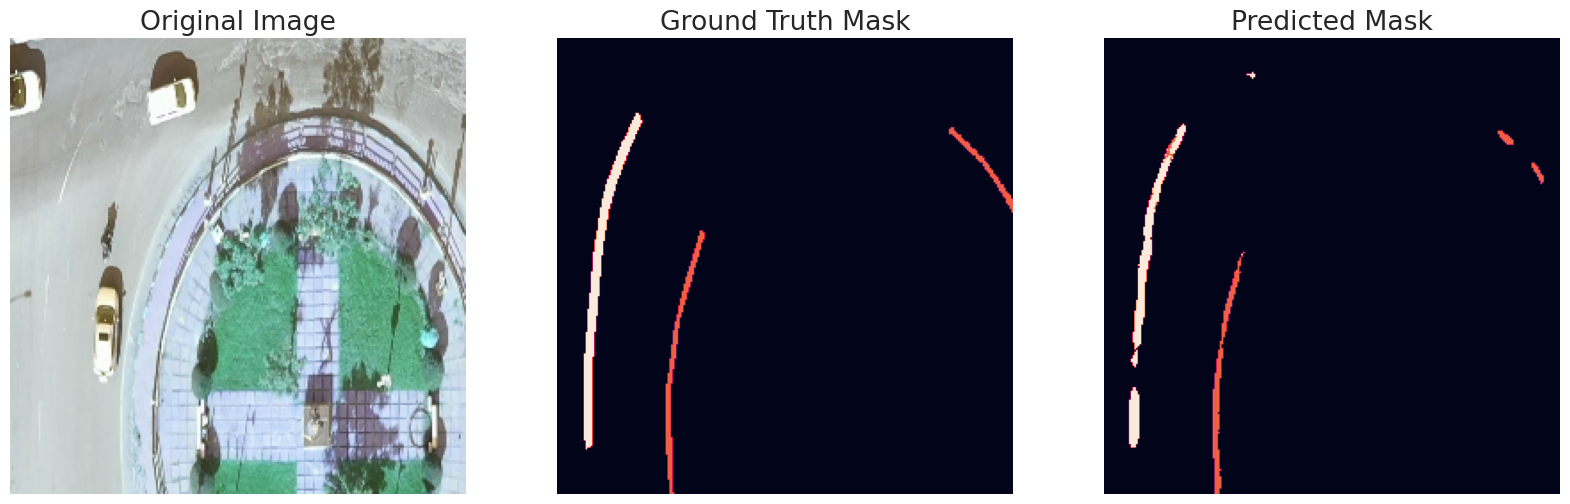

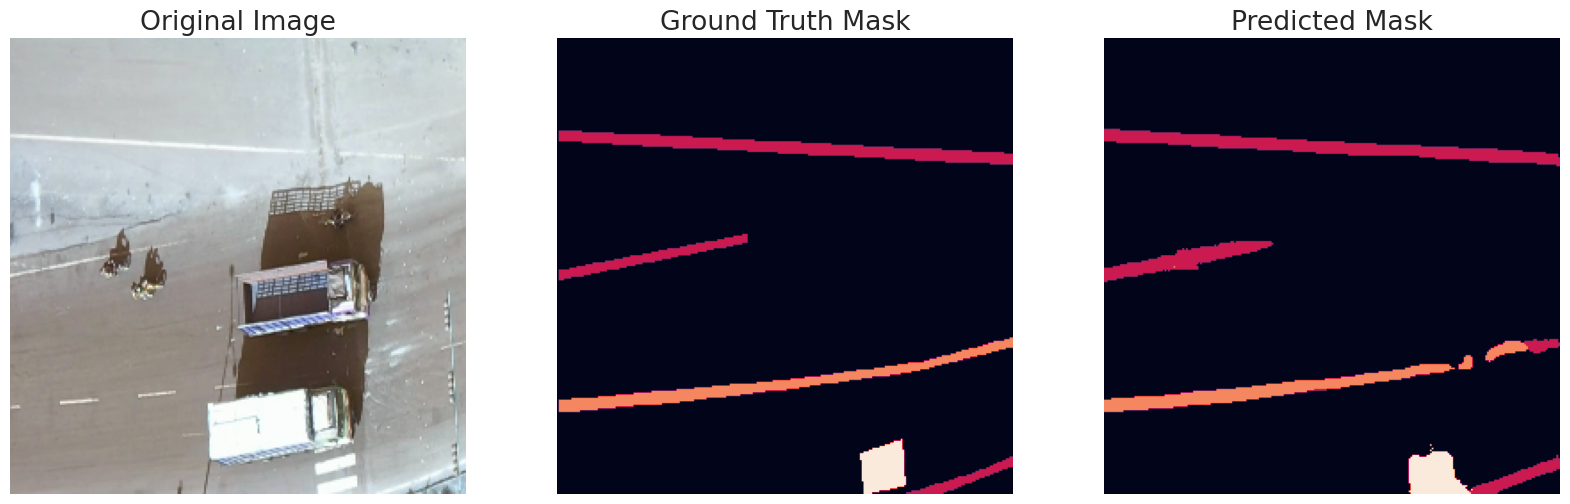

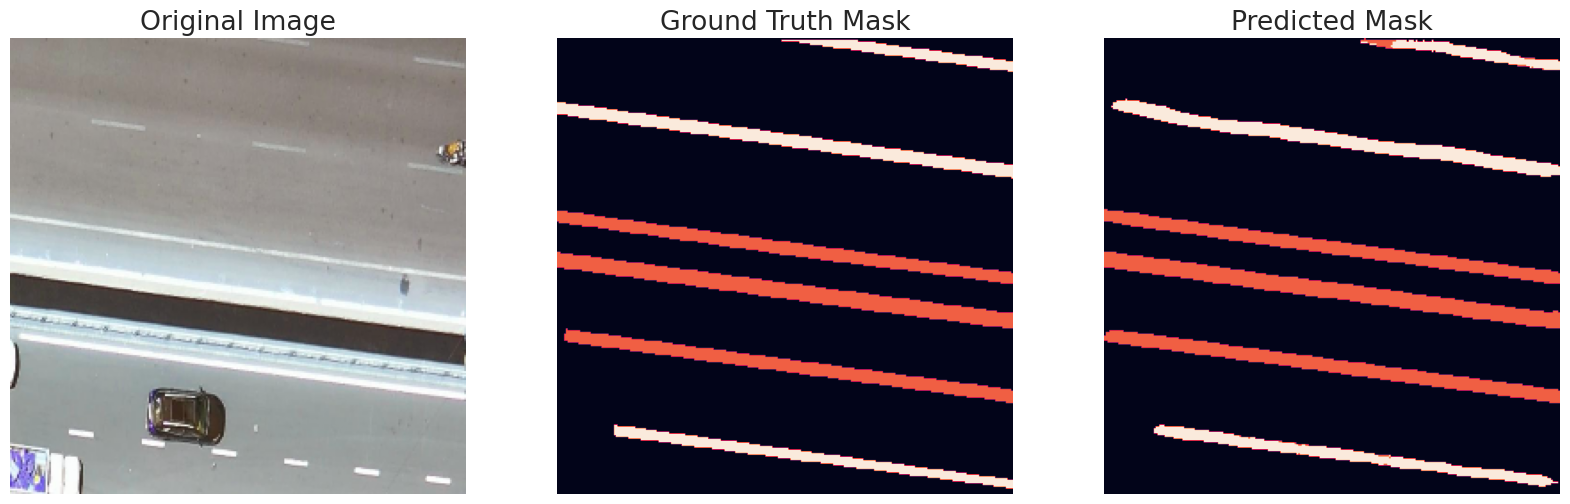

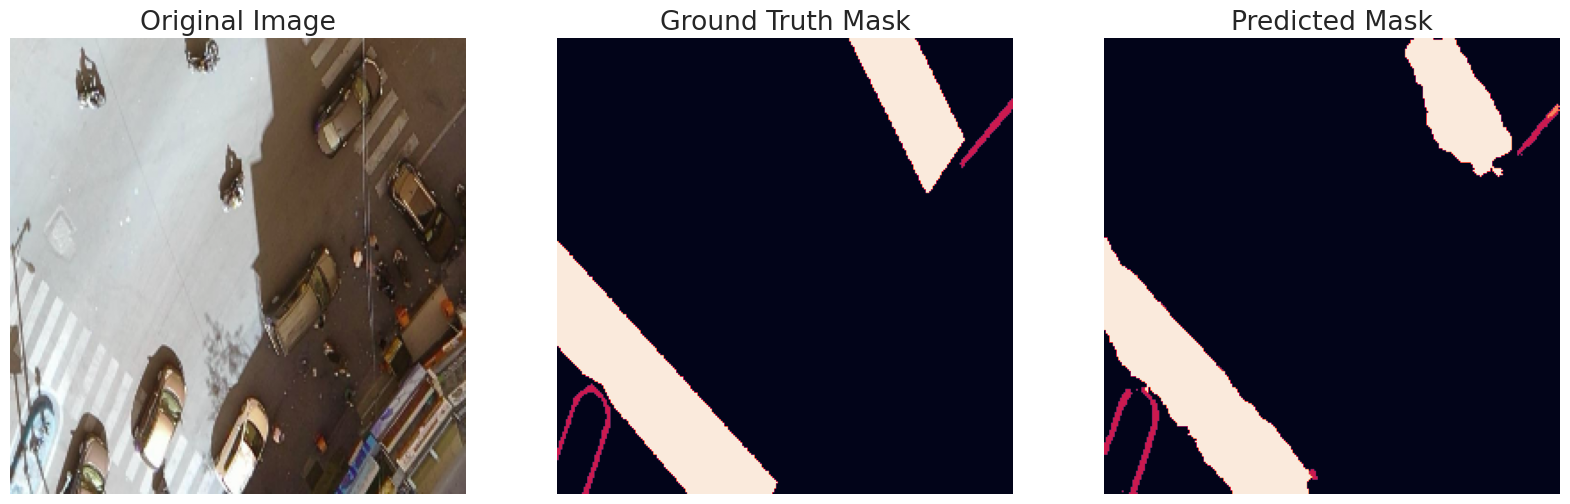

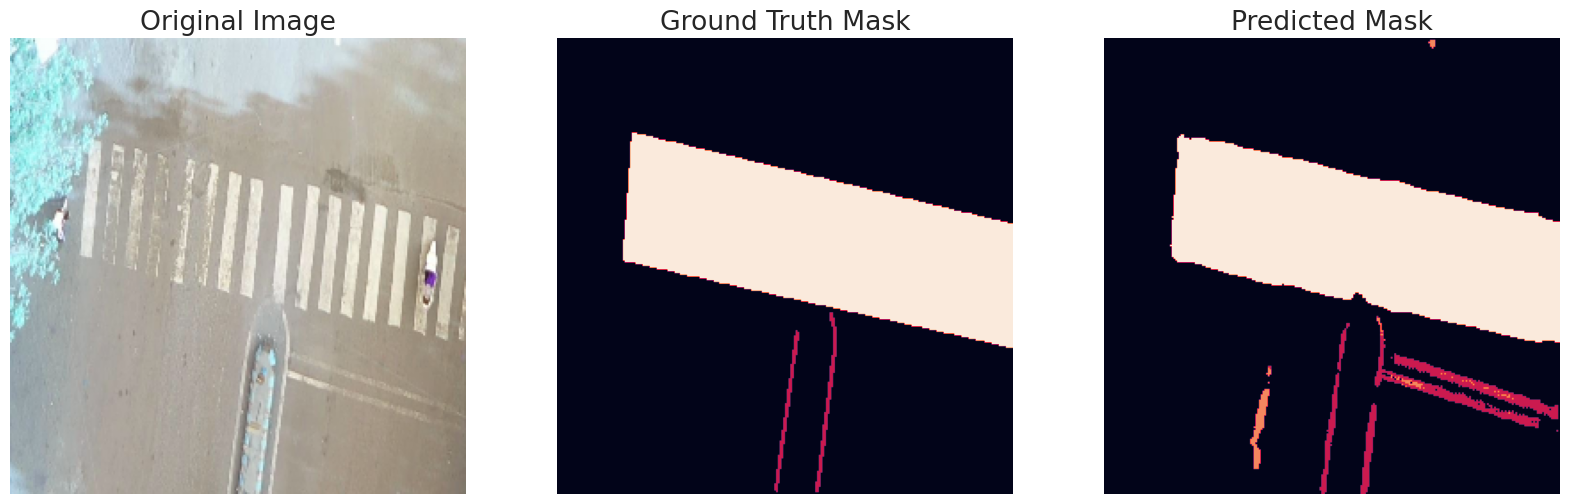

In [24]:
# Initialize the data generator for your test data
test_images_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/test'  # replace with your test images path
test_masks_path = '/kaggle/input/cv-road-marking/augmented_dataset/masks/test'  # replace with your test masks path

test_generator = NPYDataGenerator(
    images_path=test_images_path,
    masks_path=test_masks_path,
    batch_size=5,  # Set batch size to 1 for demonstration purposes
    dim=(256, 256),
    n_channels=3,
    n_classes=5,  # Set this to your actual number of classes
    shuffle=False
)

import tensorflow as tf

# Load one batch of data
test_images, test_masks = test_generator.__getitem__(0)

predicted_masks = model.predict(test_images)

predicted_masks = np.argmax(predicted_masks, axis=-1)

num_images_to_show = min(5, len(test_images))

for i in range(num_images_to_show):
#     print("x")
    plt.figure(figsize=(20, 8))
    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i])
    plt.title('Original Image')
    plt.axis('off')

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    ground_truth = np.argmax(test_masks[i], axis=-1)  # Assuming the masks are one-hot encoded
    plt.imshow(ground_truth, )
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i],)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

## Saving the Model

In [25]:
model.save('unet_multiclass_iou_good.keras')

In [ ]:
# # This is to load the model which was saved
# import tensorflow as tf

# # Load the saved model
# model = tf.keras.models.load_model('unet_multiclass_iou_good.keras')

# # Use the loaded model for inference, evaluation, or further training


TypeError: Could not locate function 'iou_coef'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'iou_coef', 'registered_name': 'function'}

In [100]:
# print(test_images.shape)
# predicted_masks = model.predict(test_images)
# print(predicted_masks.shape)
# predicted_masks[0].shape


(5, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(5, 256, 256, 5)


(256, 256, 5)

## Plotting Image and Predicted Mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


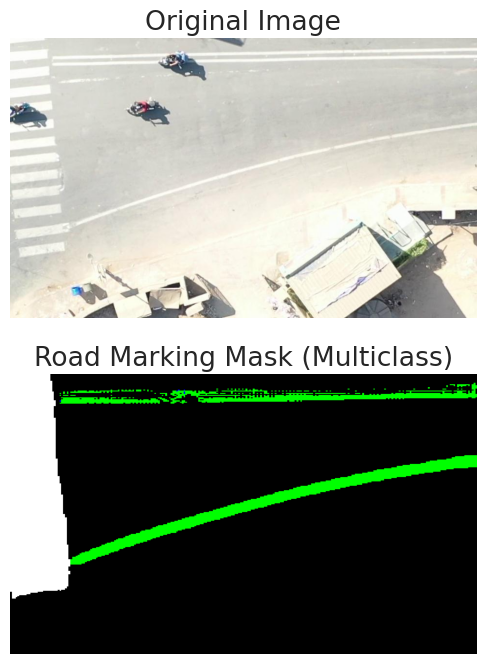

In [244]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_to_color_image(predicted_mask, class_colors):
    color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_label, color in enumerate(class_colors):
        color_mask[predicted_mask == class_label] = color

    return color_mask

def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size[::-1], interpolation=cv2.INTER_NEAREST)
    return resized_image

# Define the class colors corresponding to your model's output classes
class_colors = [
    (0, 0, 0),# black Background
    (255, 0, 0), # red traffic sign
    (0, 255, 0), # green Divider
    (0, 0, 255), # blue lane marking
    (255, 255, 255),# white Zebra- crossing
]

# Path to your original image
image_path = '/kaggle/input/cv-road-marking/augmented_dataset/images/test/v_1_64.jpg'  # Update with your image path

# Load and resize the original image to 256x256
original_image = cv2.imread(image_path)
resized_image = cv2.resize(original_image, (256, 256))



def resize_image_pillow(image_path, target_size=(256, 256), quality=100):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image while preserving aspect ratio
    image.thumbnail(target_size, Image.ANTIALIAS)

    # Convert the image to RGB (if not already in RGB mode)
    image = image.convert('RGB')

    # Save the resized image to a BytesIO object to control JPEG quality
    output = io.BytesIO()
    image.save(output, format='JPEG', quality=quality)

    # Read the resized image back from the BytesIO object
    resized_image = Image.open(output)
    resized_image = np.array(resized_image)  # Convert PIL Image to NumPy array

    return resized_image


image_size = (original_image.shape[0], original_image.shape[1])

# Convert the resized image to a numpy array and normalize it
input_image = resized_image.astype(np.float32) / 255.0

# Reshape the input image to match model's input shape (e.g., batch size of 1)
input_image = np.expand_dims(input_image, axis=0)

# Use the model to predict masks for the input image
predicted_masks = model.predict(input_image)

# Assuming predicted_masks[0] is the predicted mask for the first image in the batch
predicted_labels = np.argmax(predicted_masks[0], axis=-1)

# Create the color mask from predicted labels
color_mask = mask_to_color_image(predicted_labels, class_colors)

# Resize the color mask to the desired size (e.g., 960x576)
target_size = image_size
resized_mask = resize_image(color_mask, target_size)

# Plot the original image and resized color mask side by side
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(resized_mask)
plt.title('Road Marking Mask (Multiclass)')
plt.axis('off')

plt.show()


## Detection and classification of mask on original image

/tmp/ipykernel_34/1301096529.py:34: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integers


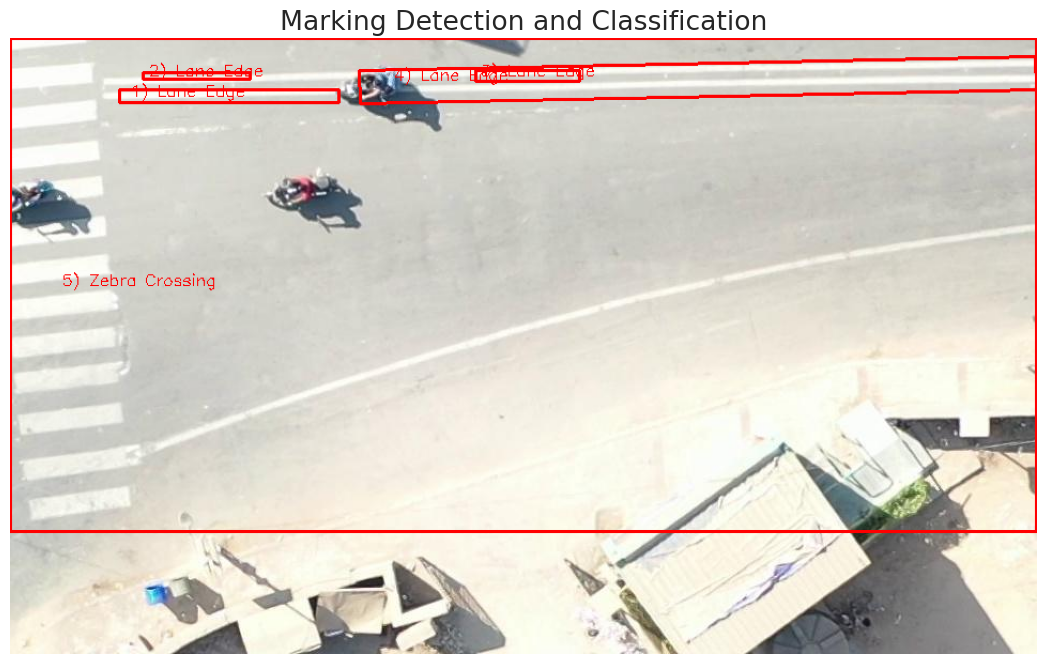

Mark 1:'Lane Edge'  Width = 205.00px, Height = 12.00px,
Mark 2:'Lane Edge'  Width = 100.00px, Height = 6.00px,
Mark 3:'Lane Edge'  Width = 97.00px, Height = 10.00px,
Mark 4:'Lane Edge'  Width = 632.13px, Height = 31.02px,
Mark 5:'Zebra Crossing'  Width = 959.00px, Height = 461.00px,


In [245]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# If possible load the saved Model Here

def find_pixel_length_width_color(mask_image, original_image):
    
    gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    dimensions = []
    contour_colors = []
    contour_labels = []

    reference_colors = {
        "Lane marking": (0, 0, 255),
        "Lane Edge": (0, 255, 0),
        "Zebra Crossing": (255, 255, 255),
        "Traffic sign": (255, 0, 0)
    }

    for contour in contours:
        # Minimum area rectangle
        area = cv2.contourArea(contour)

        # Check if contour area is above the minimum threshold
        # (if area of contour is less than 150 don't consider it)
        if area < 150:
            continue 
        
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)  
        box = np.int0(box)  

        # Calculate dimensions
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        dimensions.append((width, height))

        
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(mask_image, mask=mask)[:3]
        contour_colors.append(mean_color)

        
        min_distance = float('inf')
        assigned_label = "Unknown" # This is for marking which doesn't get identified

        for label, color in reference_colors.items():
            distance = np.linalg.norm(np.array(mean_color) - np.array(color))
            if distance < min_distance:
                min_distance = distance
                assigned_label = label

        contour_labels.append(assigned_label)

        cv2.drawContours(original_image, [box], 0, (0, 0, 255), 2)

        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)

        # Place text label inside the bounding box
        cv2.putText(original_image, f"{len(contour_labels)}) {assigned_label}", (x + int(w * 0.05), y + int(h * 0.5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Plot the image with bounding boxes and labels
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Marking Detection and Classification')
    plt.axis('off')
    plt.show()

    return dimensions, contour_colors, contour_labels

original_image = cv2.imread(image_path)
# Operations on original Image (to make in compatible to model input)
image_size = (original_image.shape[0], original_image.shape[1])
input_image = resized_image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# Model Predicts
predicted_masks = model.predict(input_image) 

# Operation on predicted mask for proper visualization
predicted_labels = np.argmax(predicted_masks[0], axis=-1)
color_mask = mask_to_color_image(predicted_labels, class_colors)
target_size = image_size
resized_mask = resize_image(color_mask, target_size)
mask_image = resized_mask

dimensions, contour_colors, contour_labels = find_pixel_length_width_color(mask_image, original_image)

# This will display details about each markings
for i, ((width, height), color, label) in enumerate(zip(dimensions, contour_colors, contour_labels), start=1):
    print(f"Mark {i}:'{label}'  Width = {width:.2f}px, Height = {height:.2f}px,")
